<a href="https://colab.research.google.com/github/vikesh3640/edge_ai/blob/main/EdgeAi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision --upgrade
!pip install "numpy<2" --upgrade
!mkdir -p edge_ai_project/scripts edge_ai_project/models


In [31]:
!ls edge_ai_project


models	scripts


In [32]:
%%writefile edge_ai_project/scripts/load_model.py
import torch
import torchvision.models as models
import torch.nn as nn
import os

SAVE_DIR = "edge_ai_project/models"
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

def save_mobilenet_fp32():
    print("Loading MobileNetV2 FP32...")
    try:
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
    except:
        print("Couldn't load pretrained weights, initializing randomly")
        model = models.mobilenet_v2(weights=None)
    model.eval()

    dummy_input = torch.randn(1, 3, 224, 224)  # random input
    traced_model = torch.jit.trace(model, dummy_input)

    save_path = os.path.join(SAVE_DIR, "mobilenet_v2_fp32.pt")
    traced_model.save(save_path)
    print("MobileNetV2 FP32 saved at:", save_path)
    # print("Verify the model file manually")

def save_lstm_fp32(input_size=8, hidden_size=64, num_layers=2, seq_len=10):
    print("Creating FP32 LSTM model...")

    class LSTMModel(nn.Module):
        def __init__(self, input_size, hidden_size, num_layers):
            super(LSTMModel, self).__init__()
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
            self.fc = nn.Linear(hidden_size, 1)

        def forward(self, x):
            out, _ = self.lstm(x)
            final_hidden = out[:, -1, :]
            # print("LSTM output shape:", final_hidden.shape)
            return self.fc(final_hidden)

    model = LSTMModel(input_size, hidden_size, num_layers)
    model.eval()

    dummy_input = torch.randn(32, seq_len, input_size)
    traced_model = torch.jit.trace(model, dummy_input)

    save_path = os.path.join(SAVE_DIR, "lstm_fp32.pt")
    traced_model.save(save_path)
    print("LSTM FP32 saved at:", save_path)

if __name__ == "__main__":
    save_mobilenet_fp32()
    save_lstm_fp32()


Overwriting edge_ai_project/scripts/load_model.py


In [33]:
!python edge_ai_project/scripts/load_model.py
!ls edge_ai_project/models


Loading MobileNetV2 FP32...
MobileNetV2 FP32 saved at: edge_ai_project/models/mobilenet_v2_fp32.pt
Creating FP32 LSTM model...
LSTM FP32 saved at: edge_ai_project/models/lstm_fp32.pt
lstm_fp32.pt  lstm_int8.pt  mobilenet_v2_fp32.pt  mobilenet_v2_int8.pt


In [34]:
%%writefile edge_ai_project/scripts/quantize_models.py
import torch
import os

SAVE_DIR = "edge_ai_project/models"
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

def quantize_model(path_fp32, path_int8):
    print("Starting quantization for:", path_fp32)
    model = torch.jit.load(path_fp32)
    model.eval()

    torch.backends.quantized.engine = "qnnpack"

    # quantizing dynamic for linear and lstm layers
    try:
        model_int8 = torch.quantization.quantize_dynamic(
            model, {torch.nn.Linear, torch.nn.LSTM}, dtype=torch.qint8
        )
    except Exception as e:
        print("Quantization failed!", e)
        return

    torch.jit.save(model_int8, path_int8)
    print("Saved INT8 model at:", path_int8)

if __name__ == "__main__":
    quantize_model(
        os.path.join(SAVE_DIR, "mobilenet_v2_fp32.pt"),
        os.path.join(SAVE_DIR, "mobilenet_v2_int8.pt")
    )
    quantize_model(
        os.path.join(SAVE_DIR, "lstm_fp32.pt"),
        os.path.join(SAVE_DIR, "lstm_int8.pt")
    )
    # print("All models quantized Success")


Overwriting edge_ai_project/scripts/quantize_models.py


In [35]:
!python edge_ai_project/scripts/quantize_models.py
!ls edge_ai_project/models


Starting quantization for: edge_ai_project/models/mobilenet_v2_fp32.pt
/content/edge_ai_project/scripts/quantize_models.py:17: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_int8 = torch.quantization.quantize_dynamic(
Saved INT8 model at: edge_ai_project/models/mobilenet_v2_int8.pt
Starting quantization for: edge_ai_project/models/lstm_fp32.pt
Saved INT8 model at: e

In [36]:
%%writefile edge_ai_project/scripts/benchmark_all.py
import torch
import time, psutil, os

SAVE_DIR = "edge_ai_project/models"
RESULTS_FILE = "benchmark_results.txt"

def measure_inference(model, dummy_input, runs=50):
    model.eval()
    with torch.no_grad():
        start_mem = psutil.Process(os.getpid()).memory_info().rss / (1024*1024)
        start_time = time.time()
        for i in range(runs):
            _ = model(dummy_input)
        end_time = time.time()
        end_mem = psutil.Process(os.getpid()).memory_info().rss / (1024*1024)
    avg_time = (end_time - start_time)*1000 / runs
    mem_used = end_mem - start_mem
    # print(f"Avg time: {avg_time}ms, Mem used: {mem_used}MB")
    return avg_time, mem_used

def benchmark_model(path_fp32, path_int8, dummy_input):
    print("Benchmarking models:", path_fp32, "and", path_int8)
    model_fp32 = torch.jit.load(path_fp32)
    model_int8 = torch.jit.load(path_int8)

    t_fp32, m_fp32 = measure_inference(model_fp32, dummy_input)
    t_int8, m_int8 = measure_inference(model_int8, dummy_input)

    model_name = os.path.basename(path_fp32).split("_")[0]  #  to get model name
    print(f"{model_name} - FP32: {t_fp32:.2f}ms/{m_fp32:.2f}MB | INT8: {t_int8:.2f}ms/{m_int8:.2f}MB")

    return {
        "model": model_name,
        "fp32_time": t_fp32,
        "fp32_mem": m_fp32,
        "int8_time": t_int8,
        "int8_mem": m_int8
    }

if __name__ == "__main__":
    results = []

    # MobileNet
    dummy_input_mn = torch.randn(1, 3, 224, 224)
    results.append(benchmark_model(
        os.path.join(SAVE_DIR, "mobilenet_v2_fp32.pt"),
        os.path.join(SAVE_DIR, "mobilenet_v2_int8.pt"),
        dummy_input_mn
    ))

    # LSTM
    dummy_input_lstm = torch.randn(32, 10, 8)
    results.append(benchmark_model(
        os.path.join(SAVE_DIR, "lstm_fp32.pt"),
        os.path.join(SAVE_DIR, "lstm_int8.pt"),
        dummy_input_lstm
    ))

    # save results
    with open(RESULTS_FILE, "w") as f:
        for r in results:
            f.write(f"{r['model']}: FP32 {r['fp32_time']:.2f}ms/{r['fp32_mem']:.2f}MB | "
                    f"INT8 {r['int8_time']:.2f}ms/{r['int8_mem']:.2f}MB\n")

    print("\nAll results saved to", RESULTS_FILE)
    # print("Check file ")


Overwriting edge_ai_project/scripts/benchmark_all.py


In [37]:
!python edge_ai_project/scripts/benchmark_all.py
!cat benchmark_results.txt


Benchmarking models: edge_ai_project/models/mobilenet_v2_fp32.pt and edge_ai_project/models/mobilenet_v2_int8.pt
mobilenet - FP32: 62.04ms/37.29MB | INT8: 46.91ms/10.18MB
Benchmarking models: edge_ai_project/models/lstm_fp32.pt and edge_ai_project/models/lstm_int8.pt
lstm - FP32: 2.73ms/2.75MB | INT8: 2.73ms/0.00MB

All results saved to benchmark_results.txt
mobilenet: FP32 62.04ms/37.29MB | INT8 46.91ms/10.18MB
lstm: FP32 2.73ms/2.75MB | INT8 2.73ms/0.00MB


In [38]:
%%writefile edge_ai_project/scripts/plot_results.py
import matplotlib.pyplot as plt

RESULTS_FILE = "benchmark_results.txt"

def read_results():
    data = {}
    with open(RESULTS_FILE, "r") as f:
        for line in f:
            parts = line.strip().split(":")
            model = parts[0]
            values = parts[1].split("|")

            # FP32 parsing
            fp32_time_str = values[0].split()[1]
            t_fp32, m_fp32 = fp32_time_str.split("ms/")
            fp32_time = float(t_fp32)
            fp32_mem = float(m_fp32.replace("MB",""))

            # INT8 parsing
            int8_time_str = values[1].split()[1]
            t_int8, m_int8 = int8_time_str.split("ms/")
            int8_time = float(t_int8)
            int8_mem = float(m_int8.replace("MB",""))

            data[model] = {
                "fp32_time": fp32_time,
                "fp32_mem": fp32_mem,
                "int8_time": int8_time,
                "int8_mem": int8_mem
            }
            # print(f"Parsed {model}")
    return data

def plot(data):
    models = list(data.keys())
    fp32_time = [data[m]["fp32_time"] for m in models]
    int8_time = [data[m]["int8_time"] for m in models]
    fp32_mem = [data[m]["fp32_mem"] for m in models]
    int8_mem = [data[m]["int8_mem"] for m in models]

    x = range(len(models))
    width = 0.35  # bar width

    fig, ax = plt.subplots(1, 2, figsize=(12,5))

    # plotting latency
    ax[0].bar([i - width/2 for i in x], fp32_time, width, label="FP32")
    ax[0].bar([i + width/2 for i in x], int8_time, width, label="INT8")
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(models)
    ax[0].set_ylabel("Time (ms)")
    ax[0].set_title("Inference Time")
    ax[0].legend()

    # plotting memory
    ax[1].bar([i - width/2 for i in x], fp32_mem, width, label="FP32")
    ax[1].bar([i + width/2 for i in x], int8_mem, width, label="INT8")
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(models)
    ax[1].set_ylabel("Memory (MB)")
    ax[1].set_title("Memory Usage")
    ax[1].legend()

    plt.tight_layout()
    # print("Plotting Successful")
    plt.show()

if __name__ == "__main__":
    data = read_results()
    plot(data)


Overwriting edge_ai_project/scripts/plot_results.py


In [39]:
%matplotlib inline
!python edge_ai_project/scripts/plot_results.py


Figure(1200x500)


In [40]:
import matplotlib.pyplot as plt

RESULTS_FILE = "benchmark_results.txt"

def read_results():
    data = {}
    with open(RESULTS_FILE, "r") as f:
        for line in f:
            parts = line.strip().split(":")
            model = parts[0]
            values = parts[1].split("|")
            # FP32
            fp32_time_str = values[0].split()[1]
            t_fp32, m_fp32 = fp32_time_str.split("ms/")
            fp32_time = float(t_fp32)
            fp32_mem = float(m_fp32.replace("MB",""))
            # INT8
            int8_time_str = values[1].split()[1]
            t_int8, m_int8 = int8_time_str.split("ms/")
            int8_time = float(t_int8)
            int8_mem = float(m_int8.replace("MB",""))
            data[model] = {
                "fp32_time": fp32_time,
                "fp32_mem": fp32_mem,
                "int8_time": int8_time,
                "int8_mem": int8_mem
            }
    return data

data = read_results()


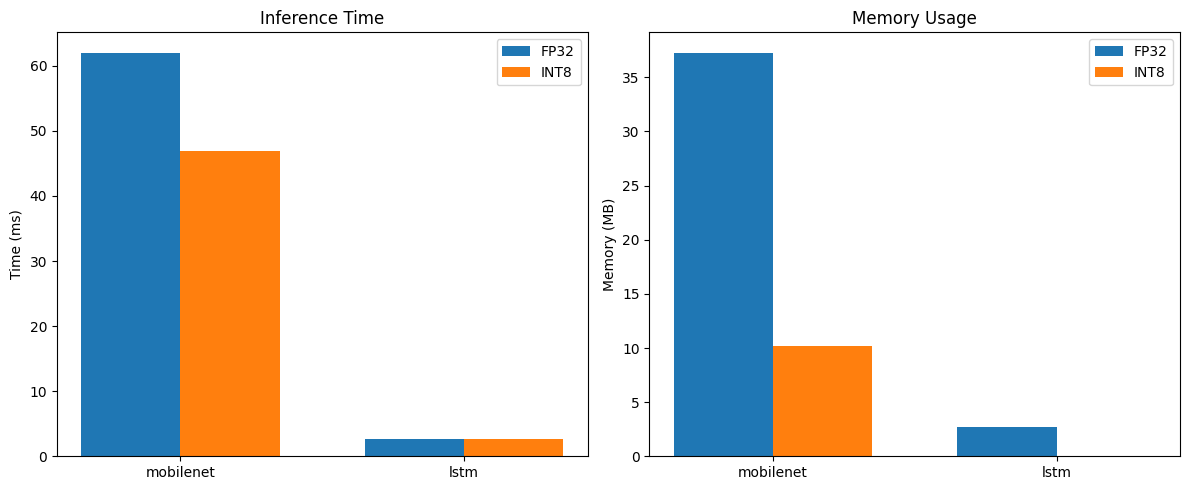

In [41]:
models = list(data.keys())
fp32_time = [data[m]["fp32_time"] for m in models]
int8_time = [data[m]["int8_time"] for m in models]
fp32_mem = [data[m]["fp32_mem"] for m in models]
int8_mem = [data[m]["int8_mem"] for m in models]

x = range(len(models))
width = 0.35

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Latency
ax[0].bar([i - width/2 for i in x], fp32_time, width, label="FP32")
ax[0].bar([i + width/2 for i in x], int8_time, width, label="INT8")
ax[0].set_xticks(x)
ax[0].set_xticklabels(models)
ax[0].set_ylabel("Time (ms)")
ax[0].set_title("Inference Time")
ax[0].legend()

# Memory
ax[1].bar([i - width/2 for i in x], fp32_mem, width, label="FP32")
ax[1].bar([i + width/2 for i in x], int8_mem, width, label="INT8")
ax[1].set_xticks(x)
ax[1].set_xticklabels(models)
ax[1].set_ylabel("Memory (MB)")
ax[1].set_title("Memory Usage")
ax[1].legend()

plt.tight_layout()
plt.show()
